In [23]:
# Python packages used:
import numpy as np # (Harris et al., 2024)
import matplotlib.pyplot as plt # # (Hunter, 2007)
import pandas as pd # (The pandas development team, 2020)
from scipy.stats import gumbel_r, linregress

## Calucalting discharge return periods

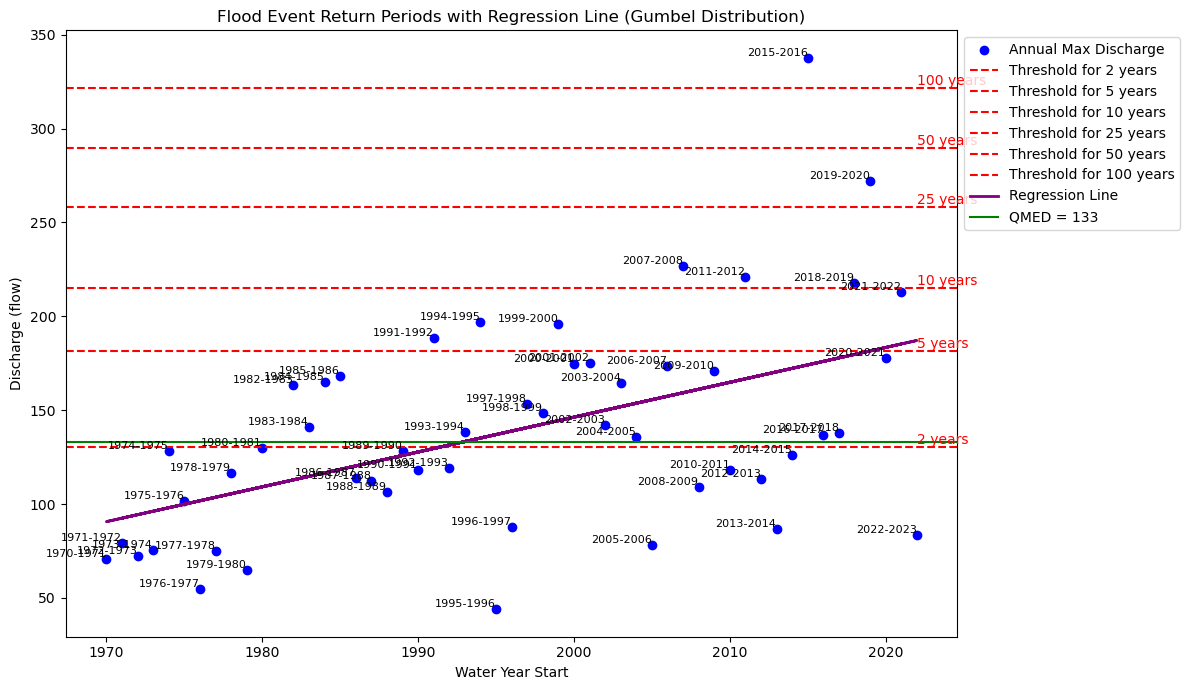

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gumbel_r
from scipy.stats import linregress

# Read the CSV file containing the discharge time series
data = pd.read_csv('AMAX_elland.csv')  

# Use water_year and flow for analysis
data['water_year_start'] = data['water_year'].str.split('-').str[0].astype(int)  # Extract the starting year of the water year
annual_max = data.set_index('water_year_start')['flow']  # Set water_year_start as the index for analysis

# Fit a Gumbel distribution to the annual maximum series
params = gumbel_r.fit(annual_max)

# Calculate the return period for each discharge value
def return_period(q):
    return 1 / (1 - gumbel_r.cdf(q, *params))

# Sort the discharge values in descending order
sorted_annual_max = annual_max.sort_values(ascending=False)

# Calculate the return period for each sorted discharge
sorted_return_periods = sorted_annual_max.apply(return_period)

# Perform linear regression on the AMAX values
years = sorted_annual_max.index.values  # Use the water year start as the x-axis
amax_values = sorted_annual_max.values  # Use the AMAX discharge values as the y-axis

slope, intercept, r_value, p_value, std_err = linregress(years, amax_values)

# Generate the regression line values
regression_line = slope * years + intercept

# Plot the discharge values with return period thresholds
plt.figure(figsize=(12, 7))
plt.scatter(sorted_annual_max.index, sorted_annual_max.values, label='Annual Max Discharge', color='blue')

# Label each point with the corresponding water year
for wy, discharge in zip(sorted_annual_max.index, sorted_annual_max.values):
    # Find the corresponding water_year string
    wy_label = data[data['water_year_start'] == wy]['water_year'].values[0]
    plt.text(wy, discharge, wy_label, fontsize=8, ha='right', va='bottom', color='black')

# Define return periods for plotting thresholds (e.g., 2, 5, 10, 50, 100 years)
threshold_return_periods = [2, 5, 10, 25, 50, 100]
for rp in threshold_return_periods:
    threshold_q = gumbel_r.ppf(1 - 1 / rp, *params)
    plt.axhline(y=threshold_q, color='red', linestyle='--', label=f'Threshold for {rp} years')

    # Annotate the return period on the plot
    plt.text(
        max(sorted_annual_max.index),  # Place text near the far-right side of the plot
        threshold_q,  # y-position (discharge value)
        f'{rp} years',  # Text to display
        color='red',
        verticalalignment='bottom',  # Align text below the line
        horizontalalignment='left',  # Align text to the left
        fontsize=10
    )

# Plot the regression line
plt.plot(years, regression_line, color='purple', label='Regression Line', linestyle='-', linewidth=2)

# QMED threshold (example given)
QMED = 133  # Replace with actual QMED if available
plt.axhline(y=QMED, color='green', linestyle='-', label=f'QMED = {QMED}')

# Labels and title
plt.xlabel('Water Year Start')
plt.ylabel('Discharge (flow)')
plt.title('Flood Event Return Periods with Regression Line (Gumbel Distribution)')

# Place the legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

# Adjust layout to make room for the legend
plt.tight_layout()

# Show plot
plt.show()
